Problem:

The network’s retention team has contacted the Analytics team to help it identify the profiles of the customers who are more likely to churn (cancel their subscription). An offer package of 50% discount for 6 months was already designed and signed off by senior stakeholders to save the customers who are more likely to churn.

1. There are two datasets provided: Dataset 1 has information on customer profiles with monthly usage details, while Dataset 2 has customer ids, their current subscription status and the average number of calls they make in a month. We would like you to combine the two datasets into one but by using SQL joins, for example via PySpark.

In [1]:
# Import the neccessary modules
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier as sklearnDecisionTreeClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance


# create a Spark Context that if we were to connect to a cluster, would be neccessary
sc = pyspark.SparkContext()

# create a Spark Session, which could be seen as an interface to the context
ss = SparkSession.builder.getOrCreate()

# create schema rather than infer schema to reduce processing time
schema1 = StructType([
    StructField("customerID", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("SeniorCitizen", IntegerType(), True),
    StructField("Partner", StringType(), True),
    StructField("Dependents", StringType(), True),
    StructField("tenure", IntegerType(), True),
    StructField("PhoneService", StringType(), True),
    StructField("MultipleLines", StringType(), True),
    StructField("InternetService", StringType(), True),
    StructField("OnlineSecurity", StringType(), True),
    StructField("OnlineBackup", StringType(), True),
    StructField("DeviceProtection", StringType(), True),
    StructField("TechSupport", StringType(), True),
    StructField("StreamingTV", StringType(), True),
    StructField("StreamingMovies", StringType(), True),
    StructField("Contract", StringType(), True),
    StructField("PaperlessBilling", StringType(), True),
    StructField("PaymentMethod", StringType(), True),
    StructField("MonthlyCharges", DoubleType(), True),
    StructField("TotalCharges", DoubleType(), True),
    StructField("SubscriptionCancelled", StringType(), True),
])

schema2 = StructType([
    StructField("CustomerId", StringType(), True),
    StructField("SubscriptionStatus", StringType(), True),
    StructField("CallsPerMonth", IntegerType(), True),
])

# read in the csv files, indicate there is a header line, use the default comma 
# seperator and infer the schema to give appropriate data types
dataset1 = ss.read.csv("dataset1.csv", header=True, schema=schema1)
dataset2 = ss.read.csv("dataset2.csv", header=True, schema=schema2)

# create a view of the datasets so that we can use SQL queries on them, in this case to merge them.
# This could have been done without the view, however it would not have used SQL and so would not have sufficed
dataset1.createOrReplaceTempView("dataset1")
dataset2.createOrReplaceTempView("dataset2")

# create an SQL query to merge our datasets and create a new merged dataframe from that query
query = "SELECT * FROM dataset1 JOIN dataset2 ON dataset1.customerID = dataset2.CustomerId"
merged_dataset = ss.sql(query)

# Other than for merging our datasets, the Customer ID columns have no use in our model and so we can drop these columns
# we can also drop the Subscription Cancelled column as although it is very useful and can be used to create a model 
# that is a -perfect predictor, I have assumed its knowledge is not applicable to a real world situation.
merged_dataset = merged_dataset.drop("CustomerId", "SubscriptionCancelled")

# create a view of our merged dataset
merged_dataset.createOrReplaceTempView("merged_dataset")

2. Using the combined dataset build a classification model. Your response variable here is the variable SubscriptionStatus. Please stick to a logistic regression or a couple of classification techniques at most. We are interested in understanding the modelling framework that you have chosen (from data prep, exploration, model evaluation and methodological decisions).
    
    One question which we would like answered is that given the accuracy of your model, what would be 
    the misclassification cost of your model if a 50% discount for 6 months are provided to all churn 
    risky customers? (Answer this based on the datasets that you have been provided).

Data Exploration

In [2]:
# take a look at the head of our data 
# (If I were not explicitly using SQL, this action could have been done with merged_dataset.show(5))
query = "SELECT * FROM merged_dataset LIMIT 5"
head = ss.sql(query)
head.show()

+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+------------------+-------------+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|SubscriptionStatus|CallsPerMonth|
+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+------------------+-------------+
|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         

From this we can see what we expect the values and data types to be for each column and begin to understand our data better

In [3]:
merged_dataset.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- SubscriptionStatus: string (nullable = true)
 |-- CallsPerMonth: integer (nullable = true)



We can now see the column names easier, and the data types that were infered for each feature
As can be seen TotalCharges is considered a string where we would expect it to be a numeric value - this indicates, there is lilkely a null value in th column.
The rest of our data seems to align with the data shown by viewing the head of the dataset

In [4]:
merged_dataset.describe().show()

+-------+------+------------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+------------------+-----------------+
|summary|gender|     SeniorCitizen|Partner|Dependents|            tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|    MonthlyCharges|      TotalCharges|SubscriptionStatus|    CallsPerMonth|
+-------+------+------------------+-------+----------+------------------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+------------------+------------------+------------------+-----------------+
|  count| 

In [5]:
df = merged_dataset.toPandas()
print("Number of missing values in :")
for column_name in df.columns:
    if (df[column_name].dtype != object or column_name == "TotalCharges"):
        print(f"{column_name}\t\t\t{df[pd.to_numeric(df[column_name], errors='coerce').isnull()].shape[0]}")

Number of missing values in :
SeniorCitizen			0
tenure			0
MonthlyCharges			0
TotalCharges			11
CallsPerMonth			0


as can be seen, there are errors in 11 rows, which do not have monthly charges. This is a small number of rows and so they can be removed without issue

In [6]:
indexes = df[pd.to_numeric(df["TotalCharges"], errors='coerce').isnull()].index
df.drop(indexes, inplace=True)
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SubscriptionStatus,CallsPerMonth
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,Active,30
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,Active,10
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Cancelled,10
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,Active,29
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Cancelled,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,Active,14
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,Active,23
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,Active,23
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Cancelled,12


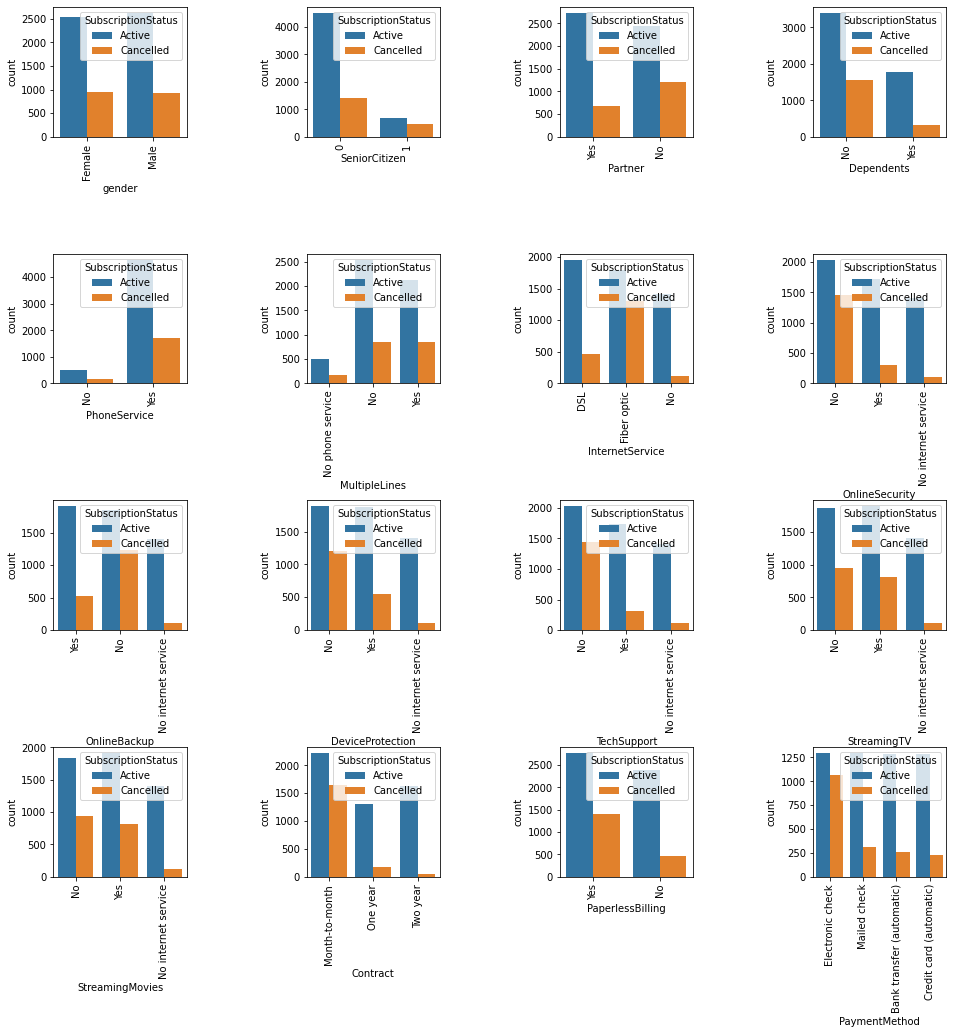

In [7]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
plt.subplots_adjust(wspace=0.9, 
                    hspace=0.9)
catagorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']
for i in range(4):
    for j in range(4):
        sns.countplot(ax=ax[i, j], x=catagorical_features[i*4+j], hue="SubscriptionStatus", data=df)
        ax[i, j].set_xticklabels(ax[i, j].get_xticklabels(), rotation=90)

In [8]:
for col in df.columns:
    if col != "CallsPerMonth_bins":
        print(col)

gender
SeniorCitizen
Partner
Dependents
tenure
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
MonthlyCharges
TotalCharges
SubscriptionStatus
CallsPerMonth


In [9]:
from sklearn.preprocessing import MinMaxScaler

<AxesSubplot:xlabel='SubscriptionStatus', ylabel='tenure'>

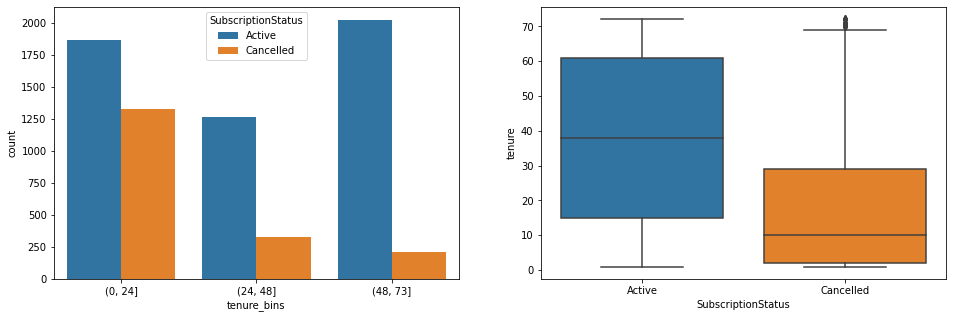

In [10]:
df["tenure_bins"] = pd.cut(x=df["tenure"], bins=[0, 24, 48, 73])

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(ax=ax[0], x="tenure_bins", hue="SubscriptionStatus", data=df)
sns.boxplot(ax=ax[1], x="SubscriptionStatus", y="tenure", data=df)

<AxesSubplot:xlabel='SubscriptionStatus', ylabel='MonthlyCharges'>

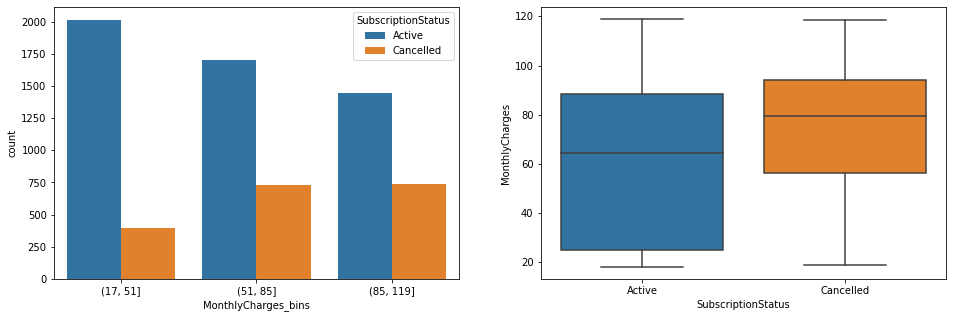

In [11]:
df["MonthlyCharges_bins"] = pd.cut(x=df["MonthlyCharges"], bins=[17, 51, 85, 119])

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(ax=ax[0], x="MonthlyCharges_bins", hue="SubscriptionStatus", data=df)
sns.boxplot(ax=ax[1], x="SubscriptionStatus", y="MonthlyCharges", data=df)

<AxesSubplot:xlabel='SubscriptionStatus', ylabel='TotalCharges'>

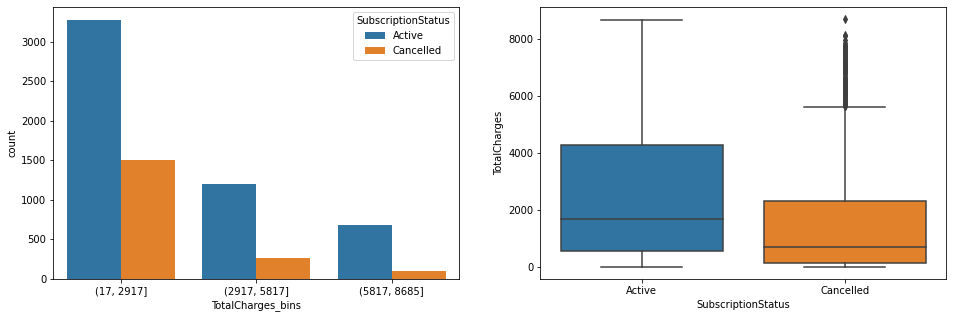

In [12]:
df["TotalCharges_bins"] = pd.cut(x=df["TotalCharges"], bins=[17, 2917, 5817, 8685])

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(ax=ax[0], x="TotalCharges_bins", hue="SubscriptionStatus", data=df)
sns.boxplot(ax=ax[1], x="SubscriptionStatus", y="TotalCharges", data=df)

<AxesSubplot:xlabel='SubscriptionStatus', ylabel='CallsPerMonth'>

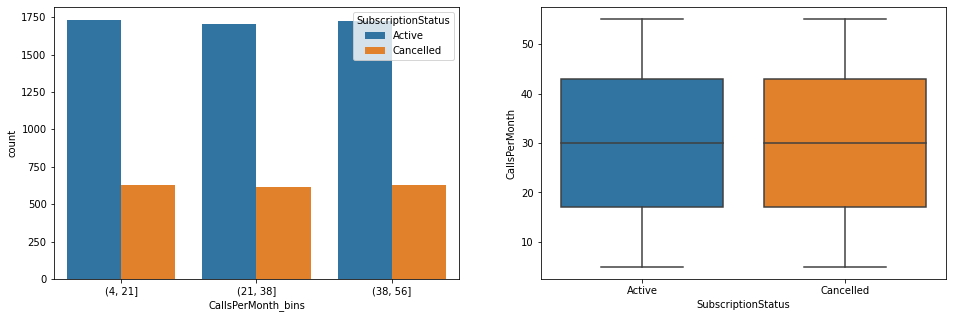

In [13]:
df["CallsPerMonth_bins"] = pd.cut(x=df["CallsPerMonth"], bins=[4, 21, 38, 56])

fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.countplot(ax=ax[0], x="CallsPerMonth_bins", hue="SubscriptionStatus", data=df)
sns.boxplot(ax=ax[1], x="SubscriptionStatus", y="CallsPerMonth", data=df)

Data Preperation

In [14]:
# now we want to return our pandas dataframe to a pyspark dataframe.
# in order to do this, we have to remove columns that have used arrays to bin our values
df.drop(["TotalCharges_bins", "MonthlyCharges_bins", "tenure_bins"], axis=1, inplace=True)

In [15]:
schema = StructType([
    StructField("gender", StringType(), True),
    StructField("SeniorCitizen", IntegerType(), True),
    StructField("Partner", StringType(), True),
    StructField("Dependents", StringType(), True),
    StructField("tenure", IntegerType(), True),
    StructField("PhoneService", StringType(), True),
    StructField("MultipleLines", StringType(), True),
    StructField("InternetService", StringType(), True),
    StructField("OnlineSecurity", StringType(), True),
    StructField("OnlineBackup", StringType(), True),
    StructField("DeviceProtection", StringType(), True),
    StructField("TechSupport", StringType(), True),
    StructField("StreamingTV", StringType(), True),
    StructField("StreamingMovies", StringType(), True),
    StructField("Contract", StringType(), True),
    StructField("PaperlessBilling", StringType(), True),
    StructField("PaymentMethod", StringType(), True),
    StructField("MonthlyCharges", DoubleType(), True),
    StructField("TotalCharges", DoubleType(), True),
    StructField("SubscriptionStatus", StringType(), True),
    StructField("CallsPerMonth", IntegerType(), True),
])
df.to_csv("merged_df.csv", index=False)

In [16]:
def min_max_scaler(dataset, cols_to_scale):
    '''Takes a dataframe and list of columns to minmax scale. Returns a dataframe'''
    for col in cols_to_scale:
        # Define min and max values and collect them
        maximum = dataset.agg({col: 'max'}).collect()[0][0]
        minimum = dataset.agg({col: 'min'}).collect()[0][0]
        new_column_name = 'scaled_' + col
        # Create a new column based off the scaled data
        dataset = dataset.withColumn(new_column_name, (dataset[col] - minimum) / (maximum - minimum))
        dataset = dataset.drop(col)
    return dataset

In [17]:
def labelSubscriptionStatus(dataset):
    dataset = StringIndexer(inputCol="SubscriptionStatus", outputCol="label").fit(dataset).transform(dataset)
    dataset = dataset.drop("SubscriptionStatus")
    return dataset

In [18]:
def string_to_catagorical(dataset):
    '''Takes all string variables in a dataframe and returns a catagorical version, excluding SubscriptionStatus '''
    for (col, dtype) in dataset.dtypes:
        if dtype == "string":
            if col != "SubscriptionStatus":
                dataset = StringIndexer(inputCol=f"{col}", outputCol=f"{col}_idx").fit(dataset).transform(dataset)
                dataset = dataset.drop(col)
    return dataset

In [19]:
def create_dataset(predictor_variables="all", catagorise_string_data=False, scale_numeric_data=False):
    '''create a dataframe by:
        taking in chosen feature variables
        optionally catagorising string variables
        optionally scaling continuous data with custom MinMaxScaler function
        labeling the response variable
        assembling the chosen feature variables
        '''
    # read in the merged dataset
    dataset = ss.read.csv("merged_df.csv", header=True, schema=schema)
    
    # label response variable
    dataset = labelSubscriptionStatus(dataset)
    
    if catagorise_string_data:
        dataset = string_to_catagorical(dataset)
        
    if scale_numeric_data:
        dataset = min_max_scaler(dataset, ["MonthlyCharges", "TotalCharges", "tenure", "CallsPerMonth"])
    
    # collect predictor varialbes
    if predictor_variables == "all":
        predictor_variables = []
        for col in dataset.columns:
            # do not include target column
            if col != "label":
                predictor_variables.append(col)
                
    # assemble chosen feature variables
    dataset = VectorAssembler(inputCols=predictor_variables, outputCol="features").transform(dataset)
    
    return dataset

In [20]:
def show_feature_importance(dataset):
    df = dataset.toPandas()
    X = df.drop(["label", "features"], axis=1)
    y = df["label"]

    # fit model to training data
    xgb_model = XGBClassifier(random_state=73)
    xgb_model.fit(X, y)

    # print feature importances
    print()
    
    imps = xgb_model.get_booster().get_score(importance_type= "gain")
    
    keys = []
    values = []
    
    for key in imps.keys():
        keys.append(key)
        values.append(imps[key])
        
    plt.barh(keys, values)
    plt.xlabel("Feature Importance")
    plt.show()

In [21]:
# create dataset to calculate feature importances
data = create_dataset(catagorise_string_data=True)
scaled_data = create_dataset(catagorise_string_data=True, scale_numeric_data=True)

c:\users\robfl\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:09:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.



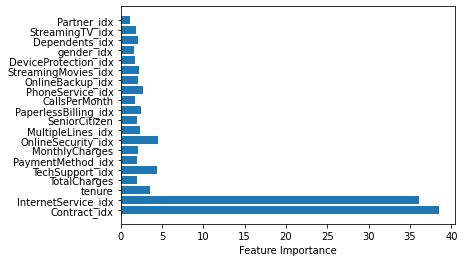

In [22]:
show_feature_importance(data)

[16:09:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.



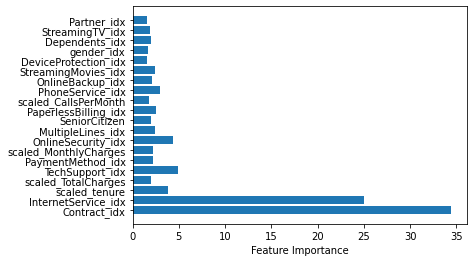

In [23]:
show_feature_importance(scaled_data)

In [24]:
# create dataset for Decision Tree
dt_dataset = create_dataset(catagorise_string_data=True)

# create dataset for Logistic Regression, including only numeric columns
lr_numeric_dataset = create_dataset(predictor_variables=["MonthlyCharges", "TotalCharges", "tenure", "CallsPerMonth"])

# create dataset for Logistic Regression, including only scaled numeric columns
scaled_lr_numeric_dataset = create_dataset(predictor_variables=["scaled_MonthlyCharges", "scaled_TotalCharges", "scaled_tenure", "scaled_CallsPerMonth"], scale_numeric_data=True)

# create dataset for Logistic Regression, including only numeric columns
lr_total_dataset = create_dataset(catagorise_string_data=True)

# create dataset for Logistic Regression, including only scaled numeric columns
scaled_lr_total_dataset = create_dataset(catagorise_string_data=True, scale_numeric_data=True)

# create a Logistic Regression model using only the 6 'most important' features
scaled_lr_fi_dataset = create_dataset(predictor_variables=["Contract_idx", "InternetService_idx", "TechSupport_idx", "OnlineSecurity_idx", "scaled_tenure", "PhoneService_idx"], scale_numeric_data=True, catagorise_string_data=True)

Training and Evaluating our models

In [25]:
def train_and_evaluate_model(classifier, dataset, numberOfDatasetSplits=1):
    '''Takes a dataset and a classifier, trains a model and prints the head of the predictions dataset and the confusion matrix'''
    # split the dataset in to 70% training and 30% testing data
    train_data, test_data = dataset.randomSplit([0.7, 0.3], seed=73)
    
    # we'll first collect the accuracy of the model on the training data, this can be compared to the accuracy of the 
    # model on the test data to see if our model over or underfuts the data. This will also be helped with later 
    # knoledge offeature feature importance
    model = classifier.fit(train_data)
    training_prediction = model.transform(test_data)
    training_TN = training_prediction.filter("prediction = 0 AND label = prediction").count()
    training_TP = training_prediction.filter("prediction = 1 AND label = prediction").count()
    training_FN = training_prediction.filter("prediction = 0 AND label != prediction").count()
    training_FP = training_prediction.filter("prediction = 1 AND label != prediction").count()
    training_accuracy = (training_TN + training_TP) / (training_TN + training_TP + training_FN + training_FP)
    
    # create predictions based on the test data
    prediction = model.transform(test_data)
    
    # show these predictions and the resulting confusion matrix
    print("First 5 predictions")
    prediction.select("label", "prediction", "probability").show(5, False)
    
    print()
    print("Confusion matrix")
    prediction.groupBy("label", "prediction").count().show()
    
    # calculate the accuracy FP = false positive ...
    TN = prediction.filter("prediction = 0 AND label = prediction").count()
    TP = prediction.filter("prediction = 1 AND label = prediction").count()
    FN = prediction.filter("prediction = 0 AND label != prediction").count()
    FP = prediction.filter("prediction = 1 AND label != prediction").count()
    
    #calculate metrics
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    
    print()
    print(f"Training Accuracy: {training_accuracy}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    
    # create roc curve
    y_test = test_data.toPandas()["label"]
    y_pred_prob = prediction.select("probability").toPandas()["probability"].map(lambda x: x[1])
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    auc = roc_auc_score(y_test, y_pred_prob)
    # compute auc score
    print(f"AUC score: {auc}")
    
    if numberOfDatasetSplits > 1:

        # create empty metric lists
        accuracies = []
        precisions =[]
        recalls = []

        for s in range(numberOfDatasetSplits):
            # create random split of our data, train the model on this splt and collect metrics
            print()
            print(f"Training model on data split {s+1}")
            train_data, test_data = dataset.randomSplit([0.7, 0.3], seed=s)
            prediction = classifier.fit(train_data).transform(test_data)
            TN = prediction.filter("prediction = 0 AND label = prediction").count()
            TP = prediction.filter("prediction = 1 AND label = prediction").count()
            FN = prediction.filter("prediction = 0 AND label != prediction").count()
            FP = prediction.filter("prediction = 1 AND label != prediction").count()
            accuracy = (TN + TP) / (TN + TP + FN + FP)
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)

            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)

        # calculate summary metrics
        mean_accuracy = np.mean(accuracies)
        mean_precision = np.mean(precisions)
        mean_recall = np.mean(recalls)

        print()
        print(f"Mean Accuracy:\t   {mean_accuracy}")
        print(f"Mean Precision:   {mean_precision}")
        print(f"Mean Recall:\t   {mean_recall}")
    return accuracy, precision, recall, auc, training_accuracy

First 5 predictions
+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0.0  |0.0       |[0.7193877551020408,0.28061224489795916]|
|0.0  |0.0       |[0.7193877551020408,0.28061224489795916]|
|0.0  |0.0       |[0.7193877551020408,0.28061224489795916]|
|0.0  |0.0       |[0.7193877551020408,0.28061224489795916]|
|0.0  |0.0       |[0.7193877551020408,0.28061224489795916]|
+-----+----------+----------------------------------------+
only showing top 5 rows


Confusion matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  319|
|  0.0|       1.0|  206|
|  1.0|       0.0|  262|
|  0.0|       0.0| 1312|
+-----+----------+-----+


Training Accuracy: 0.7770366841353026
Accuracy: 0.7770366841353026
Precision: 0.6076190476190476
Recall: 0.5490533562822719


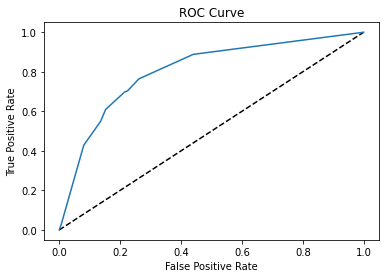

AUC score: 0.8046001056739664

Training model on data split 1

Training model on data split 2

Mean Accuracy:	   0.7882274594789833
Mean Precision:   0.6296551074255561
Mean Recall:	   0.5234734314888201


In [26]:
dt = train_and_evaluate_model(DecisionTreeClassifier(), dt_dataset, 2)

First 5 predictions
+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0.0  |0.0       |[0.7028522368021943,0.29714776319780567]|
|0.0  |0.0       |[0.7043723418405284,0.29562765815947156]|
|1.0  |0.0       |[0.6395609218559166,0.3604390781440834] |
|0.0  |0.0       |[0.6335721983603184,0.3664278016396816] |
|1.0  |0.0       |[0.5639354439517327,0.4360645560482673] |
+-----+----------+----------------------------------------+
only showing top 5 rows


Confusion matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  233|
|  0.0|       1.0|  121|
|  1.0|       0.0|  323|
|  0.0|       0.0| 1422|
+-----+----------+-----+


Training Accuracy: 0.7884707003334921
Accuracy: 0.7884707003334921
Precision: 0.6581920903954802
Recall: 0.41906474820143885


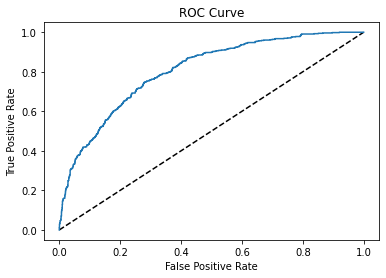

AUC score: 0.8052232873454963

Training model on data split 1

Training model on data split 2

Mean Accuracy:	   0.7858910108808524
Mean Precision:   0.6122720091914404
Mean Recall:	   0.4616454973597831


In [27]:
lr_numeric = train_and_evaluate_model(LogisticRegression(), lr_numeric_dataset, 2)

First 5 predictions
+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0.0  |0.0       |[0.8921516103085749,0.10784838969142507]|
|0.0  |0.0       |[0.712300625477912,0.28769937452208805] |
|1.0  |0.0       |[0.7117789157377898,0.28822108426221016]|
|0.0  |0.0       |[0.7162662608907132,0.2837337391092868] |
|1.0  |0.0       |[0.7964853099728083,0.2035146900271917] |
+-----+----------+----------------------------------------+
only showing top 5 rows


Confusion matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  245|
|  0.0|       1.0|  123|
|  1.0|       0.0|  338|
|  0.0|       0.0| 1393|
+-----+----------+-----+


Training Accuracy: 0.7803716055264411
Accuracy: 0.7803716055264411
Precision: 0.6657608695652174
Recall: 0.4202401372212693


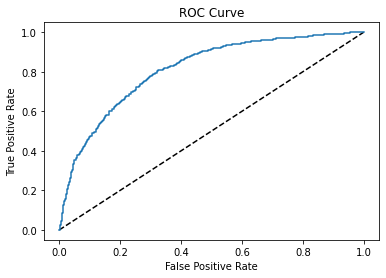

AUC score: 0.8118276406721671

Training model on data split 1

Training model on data split 2

Mean Accuracy:	   0.7839507426971872
Mean Precision:   0.6501180213464697
Mean Recall:	   0.4480429316048388


In [28]:
scaled_lr_numeric = train_and_evaluate_model(LogisticRegression(), scaled_lr_numeric_dataset, 2)

First 5 predictions
+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0.0  |0.0       |[0.795706933083457,0.20429306691654303] |
|0.0  |0.0       |[0.8193062925143916,0.18069370748560842]|
|0.0  |0.0       |[0.8218230156601251,0.17817698433987494]|
|0.0  |0.0       |[0.7942257878822728,0.20577421211772717]|
|0.0  |0.0       |[0.866244643819602,0.13375535618039802] |
+-----+----------+----------------------------------------+
only showing top 5 rows


Confusion matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  308|
|  0.0|       1.0|  168|
|  1.0|       0.0|  273|
|  0.0|       0.0| 1350|
+-----+----------+-----+


Training Accuracy: 0.7898999523582658
Accuracy: 0.7898999523582658
Precision: 0.6470588235294118
Recall: 0.5301204819277109


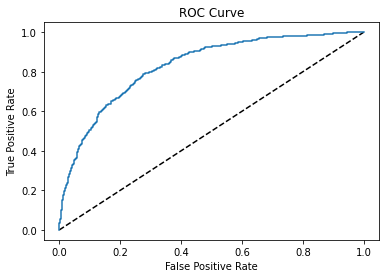

AUC score: 0.8297061764845944

Training model on data split 1

Training model on data split 2

Mean Accuracy:	   0.8101099372432163
Mean Precision:   0.6795457357307819
Mean Recall:	   0.5364274488251232


In [29]:
lr_total = train_and_evaluate_model(LogisticRegression(), lr_total_dataset, 2)

First 5 predictions
+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0.0  |1.0       |[0.277173403614735,0.7228265963852649]  |
|0.0  |1.0       |[0.2790981228027146,0.7209018771972854] |
|0.0  |0.0       |[0.5613792114227815,0.43862078857721853]|
|0.0  |0.0       |[0.6603611444066034,0.33963885559339657]|
|0.0  |1.0       |[0.47123948579061264,0.5287605142093874]|
+-----+----------+----------------------------------------+
only showing top 5 rows


Confusion matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  281|
|  0.0|       1.0|  167|
|  1.0|       0.0|  256|
|  0.0|       0.0| 1395|
+-----+----------+-----+


Training Accuracy: 0.7984754645069081
Accuracy: 0.7984754645069081
Precision: 0.6272321428571429
Recall: 0.5232774674115456


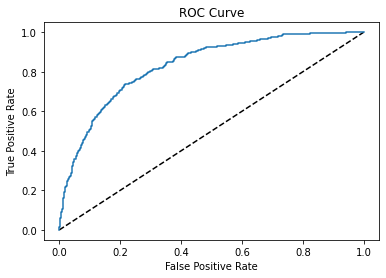

AUC score: 0.831715534445883

Training model on data split 1

Training model on data split 2

Mean Accuracy:	   0.8060228452751816
Mean Precision:   0.6567438741481804
Mean Recall:	   0.5554348883197717


In [30]:
scaled_lr_total = train_and_evaluate_model(LogisticRegression(), scaled_lr_total_dataset, 2)

First 5 predictions
+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0.0  |1.0       |[0.2866169542834198,0.7133830457165802] |
|0.0  |1.0       |[0.2866169542834198,0.7133830457165802] |
|0.0  |1.0       |[0.49855746868625406,0.5014425313137459]|
|0.0  |0.0       |[0.588234226692625,0.41176577330737496] |
|0.0  |1.0       |[0.3411523073661829,0.6588476926338172] |
+-----+----------+----------------------------------------+
only showing top 5 rows


Confusion matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  258|
|  0.0|       1.0|  158|
|  1.0|       0.0|  279|
|  0.0|       0.0| 1404|
+-----+----------+-----+


Training Accuracy: 0.7918056217246308
Accuracy: 0.7918056217246308
Precision: 0.6201923076923077
Recall: 0.48044692737430167


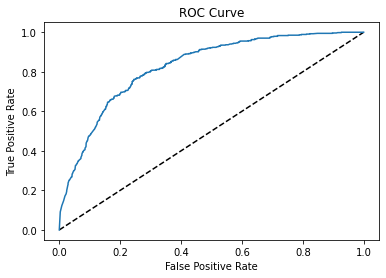

AUC score: 0.8261313266427753

Training model on data split 1

Training model on data split 2

Mean Accuracy:	   0.7993622736918145
Mean Precision:   0.6561359006879588
Mean Recall:	   0.5040944014004604


In [31]:
scaled_lr_fi = train_and_evaluate_model(LogisticRegression(), scaled_lr_fi_dataset, 2)

<ipython-input-32-efc2eeeaf6e1>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=model_names, rotation=90)


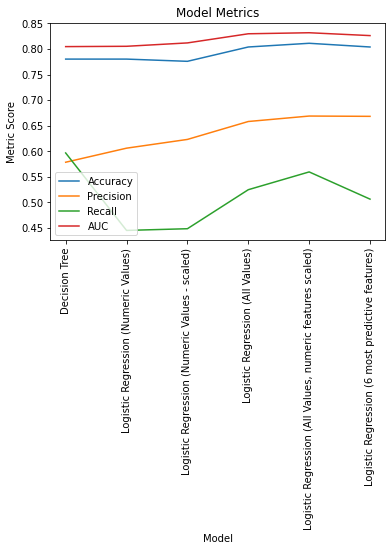

<ipython-input-32-efc2eeeaf6e1>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=model_names, rotation=90)


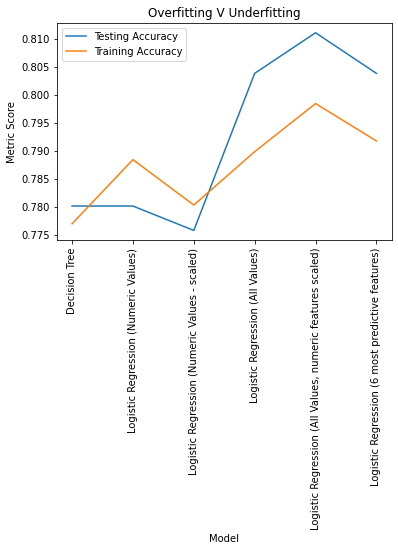

In [32]:
# collect evauated models
evaluated_models = [dt, lr_numeric, scaled_lr_numeric, lr_total, scaled_lr_total, scaled_lr_fi]
model_names = ["Decision Tree", "Logistic Regression (Numeric Values)", "Logistic Regression (Numeric Values - scaled)", "Logistic Regression (All Values)", "Logistic Regression (All Values, numeric features scaled)","Logistic Regression (6 most predictive features)"]

accuracies = []
precisions = []
recalls = []
aucs = []
training_accuracies = []

# collect metrics
for metrics in evaluated_models:
    accuracies.append(metrics[0])
    precisions.append(metrics[1])
    recalls.append(metrics[2])
    aucs.append(metrics[3])
    training_accuracies.append(metrics[4])

# plot metrics
plt.plot(model_names, accuracies, label="Accuracy")
plt.plot(model_names, precisions, label="Precision")
plt.plot(model_names, recalls, label="Recall")
plt.plot(model_names, aucs, label="AUC")
ax = plt.gca()
ax.set_xticklabels(labels=model_names, rotation=90)
ax.legend()
plt.title("Model Metrics")
plt.xlabel("Model")
plt.ylabel("Metric Score")
plt.show()


plt.plot(model_names, accuracies, label="Testing Accuracy")
plt.plot(model_names, training_accuracies, label="Training Accuracy")
plt.title("Overfitting V Underfitting")
plt.xlabel("Model")
plt.ylabel("Metric Score")
ax = plt.gca()
ax.set_xticklabels(labels=model_names, rotation=90)
ax.legend()
plt.show()

# Accuracy: Used when it is equally as important that we do not overpredict positive values as it is that we do not overpredict negative values

   The number of True Positive and True Negative values divided by the number of predictions.
    negative values.
    Does it apply?
        it is certainly a useful metric to know, but is unlikely the most useful. See other evaluation metrics below

# Precision: Used when you do not want to overpredict positive values
   The number of True Positive values divided by the number of predicted positive values.
    use case - if a company has to fly indivuals abroad to interview them costing £2000 for flights and accomodation, they may 
        wish to only fly over people they are very confident will do well in interviews and so minimise false positives
    Does it apply?
        50% is a large discount and the discount has been signed off to be given to the people 'most likely to churn' 
        indicating that overestimating the number of people that are likely to churn is likely a costmly mistake.

# Recall: Used when you do not want to miss any positive values (ussually the result of which is extreme)
   The number of True Positive values divided by the number of actual positive values.
    use case - if a patient has even a very small chance of chance of having cancer, you would want to give them further tests 
        as this cost is far less than a diagnosis later, or never, with a likely fatal ending.
        Similarly, if there is a small chance that a plane will crash due to a part failure, it is worth rechecking or 
        replacing that part as this cost is again, much less than the lives of the people boarding the plane, or the plane 
        itself.
    Does it apply?
            Losing a customer is costly. It is much more expensive to encourage a new customer to join the etwork, than it is 
            to keep a current member onboard.
            
1. The final decision should be based on the cost of retaining a customer (50% of the subscription value)
2. Does the cost of retention lead to long term loyalty, or do customers leave after the discount is withdrawn
3. What is the cost of obtaining a new cusotmer, or re-obtaining a lost customer.
4. What is the budget for this retention project

if 1 is high -> Precision may be the best metric, else recall
if 2 is high -> should we give the discount atall - perhaps only to the most vunurable oto leaving and so again precision may 
    be best
if 3 is high -> recall may be best
if 4 is high -> recall may be best

3. Prepare a short presentation of your findings, highlighting the profiles (pen portrait) of the customers that have a high risk of churning. You may also wish to suggest strategies to mitigate against these likely-to-churn customers.

In [40]:
# Making an assumption that all subscriptions cost the same
# Let cost_of_subscription be a variable that indicates the full cost of a subscription
# let success_probability be the probability that giving a discount to someone that was 
#   going to churn, actually stops them from churning
# Let missclassification_cost be the total missclassification cost
# Let misclassified_as_unlikely_to_churn be the number of people that churned due to being incorrectly classified
# Let unneccessary_discounts be the number of people that recieved a discount due to being incorrectly classified
# Let predicted_churners be the number of people that are predicted to churn

# Misclassification costs are:
#   The cost of giving a customer a discount when they were not going to churn
#   The cost of losing a customer due to them leaving because we did not give them a discount

# costs refer to lost revenue


# Using the "Logistic Regression (All Values, numeric features scaled)" Model, from the confusion matrix we get:
'''
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|  281|
|  0.0|       1.0|  167|
|  1.0|       0.0|  256|
|  0.0|       0.0| 1395|
'''

misclassified_as_unlikely_to_churn = 256
unneccessary_discounts = 167
predicted_churners = 281 + 167
predicted_churners_that_will_actually_churn = 281
number_of_people_that_churn = 281 + 256

# based on an assumed cost of £30 per month and an arbitrary success probability of 75%
#cost_of_subscription = 30
#success_probability = 0.75
cost_of_subscription = np.mean(df["MonthlyCharges"])
success_probability = 0.9


# Missclassification Cost Equation

long_term_missclassification_cost = misclassified_as_unlikely_to_churn * cost_of_subscription * success_probability
short_term_missclassification_cost = unneccessary_discounts * cost_of_subscription / 2

# Bussiness Cost Equation

number_of_people_kept_by_discount = predicted_churners_that_will_actually_churn * success_probability
long_term_cost_of_doing_nothing = number_of_people_kept_by_discount * cost_of_subscription

long_term_lost_revenue_due_to_churning_without_model = number_of_people_that_churn * cost_of_subscription
long_term_lost_revenue_due_to_churning_with_model = (number_of_people_that_churn - number_of_people_kept_by_discount) * cost_of_subscription
six_month_lost_revenue_due_to_churning_with_model = long_term_lost_revenue_due_to_churning_with_model + (predicted_churners * cost_of_subscription / 2)

# short term benifit is the costs saved by not giving discounts
short_term_benifit_of_doing_nothing = predicted_churners * cost_of_subscription / 2

print(f"Long term missclassification cost:\t\t\t\t\t£{np.round(long_term_missclassification_cost, 2)}\tper month")
print(f"Short term missclassification cost:\t\t\t\t\t£{np.round(short_term_missclassification_cost, 2)}\tper month for 6 months")
print()
print(f"Long term cost of doing nothing:\t\t\t\t\t£{np.round(long_term_cost_of_doing_nothing, 2)}\tper month")
print(f"Short term benefit of doing nothing:\t\t\t\t\t£{np.round(short_term_benifit_of_doing_nothing, 2)}\tper month for 6 months")
print()
print(f"Lost revenue over the next 6 months of people churning \nif action is taken:\t\t\t\t\t\t\t£{np.round(six_month_lost_revenue_due_to_churning_with_model, 2)}\tper month")
print(f"Long term total lost revenue of people churning if action is taken:\t£{np.round(long_term_lost_revenue_due_to_churning_with_model, 2)}\tper month")
print(f"Long term total lost revenue of people churning if nothing is done:\t£{np.round(long_term_lost_revenue_due_to_churning_without_model, 2)}\tper month")

Long term missclassification cost:					£14929.51	per month
Short term missclassification cost:					£5410.65	per month for 6 months

Long term cost of doing nothing:					£16387.47	per month
Short term benefit of doing nothing:					£14514.8	per month for 6 months

Lost revenue over the next 6 months of people churning 
if action is taken:							£32923.97	per month
Long term total lost revenue of people churning if action is taken:	£18409.17	per month
Long term total lost revenue of people churning if nothing is done:	£34796.64	per month
